In [19]:
import pandas as pd
import os
import numpy as np
import chardet
import json
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.pyplot import plt
import requests
dir = os.getcwd()

data_train1=dir+'/data/data_train_1/'
data_train2=dir+'/data/data_train_2/'
data_train3=dir+'/data/datasource6/'
test = dir+'/data/transformed_data/data_test/test/'
df_test = pd.read_csv('test_features.csv')

In [2]:
# Test Features Merging
'''dflist = []
for file in os.listdir(test):
    dflist.append(pd.read_excel(test+file,sheet_name=0).merge(pd.read_excel(test+file,sheet_name=1),on='id'))
test_merged = pd.concat(dflist)
test_merged.to_csv('test_features.csv')
'''

#df_test = pd.read_csv('test_features.csv')
'''apis = pd.read_csv('api_data.csv')
df_train = pd.read_csv('train_dataset_merged.csv')
df_train = df_train.replace('WEBSITE', np.nan)
df_train = df_train.set_index('id').combine_first(webdata.set_index('id'))
df_train = df_train.replace('API', np.nan)
df_train = df_train.combine_first(apis.set_index('id'))
'''
df_train = pd.read_csv('train_dataset_webdata_api.csv')
df_train = df_train.drop(['id',
                          'Unnamed: 0',
               'Unnamed: 0_x',
               'Unnamed: 0_y',
               'test strings (delete please)',
               'useless values (delete please)',
               'ldsa_team_wishes_you',
                          'countrycode',
                          'storeid',
                          'ddpsubcategory','country','designer','orderportalid','productid'
              ],axis=1)

# Sampling

In [3]:
# Duplicar 1s
df_train = pd.concat([df_train,
                      df_train.loc[df_train['returned']==1,:],
                      df_train.loc[df_train['returned']==1,:]],axis=0)

df_train = pd.concat([df_train.loc[df_train['returned']==1,:],
            df_train.loc[df_train['returned']==0,:].sample(250000)],axis=0)


In [4]:
df_train['returned'].value_counts()

0    250000
1    175785
Name: returned, dtype: int64

In [5]:
# Data
# df_train['country']=pd.Categorical(df_train['country'])
# df_train['countryoforigin'] = pd.Categorical(df_train['countryoforigin'])

# One Hot
df_train['issale'] = np.where(df_train['issale']=='Yes',1,0)
df_train['isvip'] = np.where(df_train['isvip']=='Not VIP',0,1)
df_train['promocode'] = np.where(df_train['promocode'] > 1, 1,0)
df_train['hasitemsonbag'] = np.where(df_train['hasitemsonbag'] == 'Yes', 1,0)
df_train['hasusedwishlist'] = np.where(df_train['hasusedwishlist'] == 'Yes', 1,0)
df_train['isreseller'] = np.where(df_train['isreseller'] == 'Yes', 1,0)

# Categorical
df_train['userfraudstatus'] = pd.Categorical(df_train['userfraudstatus'])
df_train['brand'] = pd.Categorical(df_train['brand'])
df_train['countryoforigin'] = pd.Categorical(df_train['countryoforigin'])
df_train['shiptypeid'] = pd.Categorical(df_train['shiptypeid'])

# Other
df_train['size'] = np.log10(df_train['size'])
df_train['sintime'] = np.sin(2 * np.pi * df_train['orderdate_gmt'].str.slice(11,13).astype(int) / 24.0)
df_train['costime'] = np.cos(2 * np.pi * df_train['orderdate_gmt'].str.slice(11,13).astype(int) / 24.0)

df_train

,brand,category_1stlevel,countryoforigin,ddprate,freereturn,hasitemsonbag,hasusedwishlist,isreseller,issale,isusingmultipledevices,...,shipper,shiptypeid,size,style,tierafterorder,tierbeforeorder,userfraudstatus,userid,sintime,costime
20,37.0,Clothing,2.0,5.0083,1.0,0,1,0,1,Yes,...,2.0,2.0,1.799341,42437.0,T1,T1,6.0,11921.0,-7.071068e-01,7.071068e-01
40,22.0,Bags,1.0,22.0668,1.0,0,0,0,0,No,...,2.0,2.0,1.230449,94190.0,NaN,NaN,4.0,262548.0,2.588190e-01,9.659258e-01
74,2.0,Shoes,2.0,0.0000,0.0,0,1,0,0,Yes,...,2.0,2.0,1.579784,98387.0,T4,NaN,4.0,160670.0,-9.659258e-01,2.588190e-01
83,5.0,Shoes,1.0,47.5089,1.0,0,1,0,1,No,...,2.0,2.0,1.491362,7136.0,T3,T3,3.0,231431.0,8.660254e-01,-5.000000e-01
87,37.0,Clothing,4.0,0.0000,1.0,0,0,0,0,No,...,1.0,3.0,1.146128,69394.0,T4,T4,3.0,262850.0,-9.659258e-01,-2.588190e-01
89,81.0,Accessories,34.0,0.0000,1.0,1,1,0,0,Yes,...,2.0,2.0,0.778151,6355.0,T4,T4,3.0,16147.0,7.071068e-01,-7.071068e-01
96,39.0,Clothing,23.0,0.0000,1.0,0,1,0,0,No,...,1.0,3.0,2.056905,151680.0,NaN,NaN,3.0,260672.0,-1.000000e+00,-1.836970e-16
100,386.0,Shoes,1.0,0.0000,1.0,1,1,0,0,No,...,2.0,2.0,0.698970,63944.0,NaN,NaN,3.0,148553.0,-1.000000e+00,-1.836970e-16
103,14.0,Clothing,1.0,5.0083,1.0,0,1,0,1,Yes,...,2.0,2.0,1.322219,60207.0,T4,T4,4.0,96558.0,1.000000e+00,6.123234e-17
105,60.0,Bags,4.0,0.0000,1.0,1,1,0,1,No,...,2.0,2.0,0.778151,81316.0,NaN,NaN,3.0,266282.0,-8.660254e-01,-5.000000e-01


In [ ]:
'''# CSVs from datasource_6

csvlist = []
for file in os.listdir(data_train3):
    if('.csv' in file):
        csvlist.append(pd.read_csv(data_train3+file,engine='python'))
csvlist = pd.concat(csvlist)
csvlist.to_csv('csvlist.csv')


csvlist = pd.read_csv('csvlist.csv')

# 1st Folder
a = pd.read_csv(data_train1+'datasource1.csv', encoding='latin1')
b = pd.read_csv(data_train1+'datasource3.csv', encoding='latin1',sep='|')
c = pd.read_json(data_train1+'datasource2.json', orient='split').reset_index()
c.columns=['id','shipper', 'productid', 'isreseller', 'issale', 'category_1stlevel']

# 2nd Folder
d = pd.read_json(data_train2+'datasource5.csv').reset_index()
d = d.rename(columns={"index": "id"})
e = pd.read_csv(data_train2+'datasource7.csv')
# .html
html = pd.read_csv(data_train2+'datasource4.csv')

# WebData
webdata = pd.read_csv(data_train1+'web_data.csv')

# Targets
targets = pd.read_csv('sql_output_targets.csv')[['id','returned']]

# Train Data Set
df_train = a.merge(c,on='id').merge(b,on='id').merge(d,on='id').merge(e,on='id').merge(html,on='id').merge(csvlist,on='id').merge(targets,on='id')

'''

# Features

In [ ]:
# Category 1st Level
df_train['category_1stlevel'].value_counts().head(10)

In [ ]:
# Brand
df_train['brand'].value_counts().head(10)

In [ ]:
# Country vs Country Code
# Removed Country Code, kept Country
#df_train['country'].value_counts().head(10)

## Target Encoder

In [14]:
# Target Encoder
df_baseline = df_train.copy(deep=True)

x_baseline = df_baseline.loc[:,['freereturn','size','userfraudstatus','brand','countryoforigin','category_1stlevel','tierafterorder','promocode','isvip',
                               'hasitemsonbag','hasusedwishlist','isreseller']]
y_baseline = df_baseline.loc[:,'returned']

### Train Test Split

In [15]:
# TTSplit
X_train, X_test, y_train, y_test = train_test_split(x_baseline,y_baseline, test_size = 0.20, random_state = 42 )

te = TargetEncoder(min_samples_leaf = 100)
te.fit(X_train,y_train)

TargetEncoder(cols=['userfraudstatus', 'brand', 'countryoforigin',
                    'category_1stlevel', 'tierafterorder'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=100, return_df=True,
              smoothing=1.0, verbose=0)

# Logistic Regression

In [16]:
# Baseline
lr = LogisticRegression(random_state = 42)
lr.fit(te.transform(X_train),y_train)
lr.predict_proba(te.transform(X_test).fillna(0))
roc_auc_score(y_test,lr.predict_proba(te.transform(X_test).fillna(0))[:,1])

/Users/cc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7008841667131297

# Gradient Boosting Classifier

In [17]:
gbc = GradientBoostingClassifier(random_state = 42)
gbc.fit(te.transform(X_train),y_train)
roc_auc_score(y_test,gbc.predict_proba(te.transform(X_test).fillna(0))[:,1])

0.7202174183097476

In [18]:
importance = pd.DataFrame({'features': X_train.columns,
                           'importance': gbc.feature_importances_
                          }).sort_values(by = 'importance', ascending=False)
importance

,features,importance
6,tierafterorder,0.389511
2,userfraudstatus,0.194904
3,brand,0.183268
5,category_1stlevel,0.074574
10,hasusedwishlist,0.036662
1,size,0.036009
0,freereturn,0.026345
11,isreseller,0.020180
8,isvip,0.014966
4,countryoforigin,0.014213


Text(0, 0.5, 'Features')

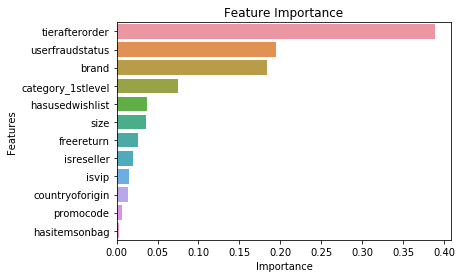

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(y = importance['features'], x = importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# Submission

In [33]:
features = df_test.loc[:,['freereturn','size','userfraudstatus','brand','countryoforigin','category_1stlevel','tierafterorder','promocode','isvip',
                               'hasitemsonbag','hasusedwishlist','isreseller']]

In [34]:
def pateta(df_train):
    # One Hot
    df_train['isvip'] = np.where(df_train['isvip']=='Not VIP',0,1)
    df_train['promocode'] = np.where(df_train['promocode'] > 1, 1,0)
    df_train['hasitemsonbag'] = np.where(df_train['hasitemsonbag'] == 'Yes', 1,0)
    df_train['hasusedwishlist'] = np.where(df_train['hasusedwishlist'] == 'Yes', 1,0)
    df_train['isreseller'] = np.where(df_train['isreseller'] == 'Yes', 1,0)

    # Categorical
    df_train['userfraudstatus'] = pd.Categorical(df_train['userfraudstatus'])
    df_train['brand'] = pd.Categorical(df_train['brand'])
    df_train['countryoforigin'] = pd.Categorical(df_train['countryoforigin'])

    # Other
    df_train['size'] = np.log10(df_train['size'])
    
    return df_train

In [35]:
features = pateta(features)

# Submission

In [36]:
ids = df_test[['id']]

In [39]:
submission = df_test[['id']]
submission['returned']=lr.predict_proba(te.transform(features).fillna(0))[:,1]
submission
submission.to_csv('SUBMISSION_04.csv',index=False)

/Users/cc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
submission

,id,returned
0,3f15fccff2058ced0fdac7cb6718a656,0.518568
1,cfb2173ff64d6b7440a47e71de9b4731,0.148670
2,3368f22dd34bf95e53395dcdfe2bcdb6,0.148670
3,cf433b79db5396f9812586c04b2cdd45,0.398692
4,9976b334d2fe399c2a2b8709e42078ec,0.382672
5,146318f8f2c880d8ad9de4845bc728f6,0.220645
6,1816e14a9e9659a1580e26f8e58d30c4,0.461942
7,fda0feb334dd8e03a6c285afbb22223a,0.332471
8,2041c8738bc67d39e8caf73ea791d649,0.209260
9,ff7457198dd67609419b5e2c7904ce90,0.240120
